# Stochastic solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import csv

##### Volume constant

In [2]:
V = 10e-12
NA = 6.023e23
# sima had V*NA*100e-9*10e-3
vna = V*NA*10e-9*10e-3
ivna = 1/vna

In [3]:
### p is the ODE system vector p=[f1, f2, f3, f4, ..., f19]
#### 0  -> clb1
#### 1  -> clb3
#### 2  -> cdc20T
#### 3  -> cdc20
#### 4  -> clb4
#### 5  -> sp
#### 6  -> cdc5t
#### 7  -> cdc5a 
#### 8  -> ndd1t
#### 9  -> ndd1a
#### 10 -> hcm1
#### 11 -> ndt80
#### 12 -> sum1iIme2
#### 13 -> sum1iCdk1
#### 14 -> sum1iRC
#### 15 -> ama1p
#### 16 -> rc
#### 17 -> dsb
#### 18 -> ama1t

## Parameters

In [4]:
#Synthesis and degradation of Clb1 :
kClb1s = 0.002
kClb1sp = 0.2
kClb1spp = 0.1
kClb1d = 0.1
kClb1dp = 0.2
kClb1dpp = 0.02
#NOTE : Decreasing Clb1 intrinsic decay rate widens Clb3 duration
kClb3s = 0.002
kClb3sp = 0.5
kClb3d = 0.2
kClb3Cdc20d = 0.2
#Cdc20
kCdc20s = 0.2
kCdc20d = 0.1
kCdc20Clb1p = 0.1
kCdc20Clb3p = 0.1
kCdc20a = 0.1
JCdc20Clb3 = 0.1
JCdc20clb1 = 0.1
JCdc20 = 0.1
kClb1Cdc20d = 0.3
kClb3Cdc20d = 0.3
#Clb1 phosophorylation of Cdc20 weaker than Clb3
#Synthesis and degradation of Clb4 :
kClb4s = 0.2
kClb4sp = 0.1
kClb4d = 0.2
kClb4dp = 1
kClb4dpp = 0.02
#Activation and inactivation of SP :
kSPa = 2
kSPi = 2
JSP = 0.01
#Synthesis, degradation, activation, and inactivation of Cdc5 :
kCdc5s = 0.004
kCdc5sp = 0.03
kCdc5spp = 0.02
kCdc5d = 0.02
kCdc5dp = 0.06
kCdc5dpp = 0.002
kCdc5a = 0.1
kCdc5ap = 0.4
kCdc5app = 0.3
kCdc5i = 0.1
#Synthesis, degradation, activation, and inacti - vation of Ndd1 :
kNdd1s = 0.03
kNdd1d = 0.0001
kNdd1dp = 1
kNdd1dpp = 0.02
kNdd1a = 0.1
kNdd1ap = 0.2
kNdd1app = 0.04
kNdd1i = 0.2
JNdd1 = 0.04
#Degradation of Hcm1 :
kHcm1d = 0.02
#Regulation of Ndt80 :
kNdt80s = 0.01
kNdt80sp = 2
kNdt80d = 0.3
JNdt80p = 0.2
alpha = 1
beta = 0.1
ki = 0.01
#degradation of Ndt80 by Ama1 :
kNdt80dp = 0.6
#Regulation of Sum1 :
kSum1i = 0.025
kSum1a = 0.000001
kSum1ip = 0.1
kSum1ipp = 1
kSum1ap = 0.01
kSum1ippp = 0.25
kSum1app = 1
#Regulation of Ama1 :
kAma1a = 0.1
kAma1i = 0.0
kAma1ip = 0.1
JAma1 = 0.1
kAIas = 10
kAIds = 1
kAma1clb3p = 0.1
#Faster rate of Ama1 phosphorylation by Clb1
#Synthesis and degradation of the additional Ama1 - inhibitor (AI) :
kAIs = 0.1
kAId = 0.15
#Activation and inactivation of the RC :
kRCa = 1
kRCi = 0.1
kRCip = 2
JRC = 0.01
#Repair of DSBs :
kDSBi = 0.02
kdmRNA = 0.1
kRim4mRNA = 100
kAma1dp = 0.01
kAma1exp = 0.08
kAma1s = 0.01

#### Gillespie Process

In [5]:
def gillespie_process(T,p,trial):     
    # current time
    t = 0
    proteins = []
    times = []
    
    while t<T:
        
        # time functions
        kDSBi = 0.02
        Sum1T = 1*vna
        Dmc1 = 1*vna
        Sum1I = lambda t: p[12]*p[13]*p[14]/(Sum1T * Sum1T)
        JNdt80 = lambda t: JNdt80p*(vna+(alpha*(Sum1T-p[12])+beta*(p[12]-Sum1I(t)))/ki)
        Ama1 = lambda t: p[18]-p[15] 
        Rim4 = lambda t: (1-math.tanh(0.2*(t-240)))/2
        
        propensities = [
        # propoensities
        # eq1
        kClb1s*vna,
        kClb1sp*p[11],
        -kClb1d*p[0],
        -kClb1dp*Ama1(t)*p[0]*ivna,
        -kClb1Cdc20d*p[3]*p[0]*ivna,
        # eq2
        kClb3s*vna,
        -kClb3d*p[1],
        -kClb3Cdc20d*p[3]*p[1]*ivna,
        5*kClb3sp*(vna-Rim4(t)*vna)*math.exp(-(t-240)/25),
        # eq3
        kCdc20s*vna,
        -kCdc20d*p[2],
        # eq4 
        (kCdc20Clb1p*p[0]*(p[2]-p[3]))/(JCdc20clb1*vna+p[2]-p[3]),
        (kCdc20Clb3p*p[1]*(p[2]-p[3]))/(JCdc20Clb3*vna+p[2]-p[3]),
        -kCdc20a*p[3]*vna/(JCdc20*vna+p[3]),
        -kCdc20d*p[3],
        # eq5
        kClb4s*vna,
        kClb4sp*p[11],
        -kClb4d*p[4],
        -kClb4dp*Ama1(t)*p[4]*ivna,
        # eq6 
        (kSPa*(p[0]+p[4])*(vna-p[5]))/(JSP*vna+vna-p[5]),
        -kSPi*vna*p[5]/(JSP*vna+p[5]),
        # eq7
        kCdc5s*vna,
        kCdc5sp*p[11],
        -kCdc5d*p[6],
        -kCdc5dp*Ama1(t)*p[6]*ivna,
        # eq8 
        kCdc5ap*ivna*p[0]*(p[6]-p[7]),
        kCdc5app*ivna*p[4]*(p[6]-p[7]),
        -kCdc5i*p[7],
        -kCdc5d*p[7],
        -kCdc5dp*Ama1(t)*p[7]*ivna,
        # eq9/eq10 none
        # eq11
        -kHcm1d*p[10],
        # eq12
        kNdt80s*vna,
        kNdt80sp*vna*p[11]/(JNdt80(t)+p[11]),
        -kNdt80d*p[11],
        -kNdt80dp*Ama1(t)*p[11]*ivna,
        # eq13 
        kSum1i*(Sum1T-p[12]),
        -kSum1a*p[12],
        # eq14 
        kSum1ip*(Sum1T-p[13]),
        kSum1ipp*ivna*(p[0]+p[4])*(Sum1T-p[13]),
        -kSum1ap*p[13],
        # eq15 
        kSum1ippp*(Sum1T-p[14]),
        -kSum1app*p[16]*p[14]*ivna,
        # eq16 
        (kAma1i*(p[18]-p[15])*vna)/(JAma1*vna+p[18]-p[15]),
        (kAma1ip*ivna*p[0]*(p[18]-p[15])*vna)/(JAma1*vna+p[18]-p[15]),
        -kAma1a*vna*p[15]/(JAma1*vna+p[15]),
        kAma1clb3p*ivna*p[1]*(p[18]-p[15])*vna/(JAma1*vna+p[18]-p[15]),
        # eq17
        (kRCa*p[17]*(vna-p[16]))/(JRC*vna+vna-p[16]),
        (-kRCi*vna*p[16])/(JRC*vna+p[16]),
        (-kRCip*p[7]*p[16]*ivna*vna)/(JRC*vna+p[16]),
        # eq18
        -kDSBi*p[17]*Dmc1*ivna,
        # eq19
        kAma1s*vna,
        -kAma1dp*p[18],
        40*kAma1s*(vna-Rim4(t)*vna)*math.exp(-(t-240)/100)
        ]
        num_props = 52
        
        # ductape (im so sorry) we wanted abs(n)/n (my fault)
        birthDeathMap = []
        for i in range(0,num_props+1):
            sign = str(propensities[i])[0]
            if sign == '-': birthDeathMap.append(-1)
            else: birthDeathMap.append(1)
        
        # create abs val of propensities list
        props = np.array(list(map(abs,propensities)))
        tot = props.sum(axis=0)
        
        # create probability array from cummulative sum
        probs = np.cumsum(props)/tot        

        # change time
        t = t - np.log(np.random.random())/tot
        times.append(t)
                
        # get a random number
        r = np.random.random()
        
        # get index where r falls in probability ranges
        index = -1
        for i in range(0,num_props+1):
            if r <= probs[i]:
                index = i
                break        
        
        # update protein count dictionary based on dice roll
        for interval in proteinMap.keys():
            if index in interval:
                if proteinCount[proteinMap[interval]] == 0 and birthDeathMap[index] == -1:
                    pass
                else:
                    proteinCount[proteinMap[interval]] += birthDeathMap[index]
        
        p = [proteinCount[key] for key in proteinCount.keys()]
        proteins.append(p)
                
    return proteins, times

#### Run single trial for testing purposes

In [6]:
trialcount = 1
runtime = 660

for i in range(0, trialcount):
    names = ['clb1','clb3','cdc20T','cdc20','clb4','sp','cdc5t','cdc5a','ndd1t','ndd1a','hcm1','ndt80','sum1iIme2','sum1iCdk1','sum1iRC','ama1p','rc','dsb','ama1t']
    p = [0,0,0,0,0,0,0,0,0,0,vna,0,0,0,0,0,0,vna,vna]

    proteinCount = {names[j] : p[j] for j in range(0,len(names))}

    proteinMap = {
        tuple(np.arange(0,5)): names[0],
        tuple(np.arange(5,9)): names[1],
        tuple(np.arange(9,11)): names[2],
        tuple(np.arange(11,15)): names[3],
        tuple(np.arange(15,19)): names[4],
        tuple(np.arange(19,21)): names[5],
        tuple(np.arange(21,25)): names[6],
        tuple(np.arange(25,30)): names[7],
        # constant rates of change for protiens 8,9
        tuple(np.arange(30,31)): names[10],
        tuple(np.arange(31,35)): names[11],
        tuple(np.arange(35,37)): names[12],
        tuple(np.arange(37,40)): names[13],
        tuple(np.arange(40,42)): names[14],
        tuple(np.arange(42,46)): names[15],
        tuple(np.arange(46,49)): names[16],
        tuple(np.arange(49,50)): names[17],
        tuple(np.arange(50,53)): names[18]
    }
    
    %time proteins, times = gillespie_process(runtime,p,i)

CPU times: user 2min 44s, sys: 555 ms, total: 2min 44s
Wall time: 2min 44s


In [14]:
from scipy.interpolate import interp1d
t = np.arange(0, runtime, 0.001)
p_interp = []

for i in range(0, len(proteins[0])):
    p_indiv = []

    for j in range(0, len(proteins)):
        p_indiv.append(proteins[j][i])

    func = interp1d(times, p_indiv, kind = 'nearest', fill_value="extrapolate")
    p = func(t)

    p_interp.append(p)

In [15]:
f = open('protein-trials/proteins.csv', 'a+', newline='\n')
with f:
    write = csv.writer(f)
    %time write.writerows(p_interp)
f.close()

CPU times: user 5.13 s, sys: 132 ms, total: 5.26 s
Wall time: 5.3 s


In [16]:
def read_proteins(file):
    proteins = []
    f = open(file,'r')
    with f:
        reader = csv.reader(f,quotechar='"')
        for row in reader:
            l = []
            for r in row: l.append(float(r))
            proteins.append(l)
    f.close()
    return proteins
%time p = read_proteins('protein-trials/proteins.csv')

CPU times: user 4.98 s, sys: 551 ms, total: 5.53 s
Wall time: 5.54 s


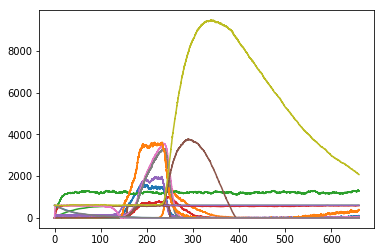

In [18]:
# plot the interpolated data
for j in range(0, len(p)):
    plt.plot(t, p[j])
plt.show()